In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import pcms.haar
import pcms.tree
import utils

In [3]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Verify functionality of CDF estimator

#### Evaluate at a single point

In [4]:
n_leaves = 100
func = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
y = 112

In [5]:
cdf_val = pcms.haar.cdf_rand_basis(y, func, eps=0.01, delta=0.01)

In [6]:
print(cdf_val)

0.9024505160553038


#### Evaluate at multiple points

In [7]:
quant50 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.5, bracket=(0,150), method='bisect', xtol=1e-3)
quant80 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.8, bracket=(0,150), method='bisect', xtol=1e-3)
quant90 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.9, bracket=(0,150), method='bisect', xtol=1e-3)
quant95 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.95, bracket=(0,150), method='bisect', xtol=1e-3)

In [8]:
print(quant50.root, quant80.root, quant90.root, quant95.root)

9.712028503417969 52.54955291748047 83.51612091064453 136.09142303466797


In [9]:
n_points = 1000
ys = np.linspace(0.1, 140, n_points)

In [10]:
cdf_vals = pcms.haar.cdf_rand_basis(ys, func, eps=0.01, delta=0.01)

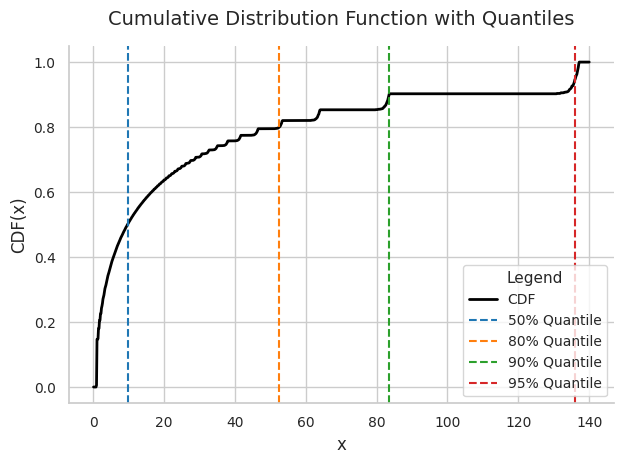

In [11]:
sns.set_theme(style="whitegrid")

# Create high-DPI figure for sharpness
fig, ax = plt.subplots()

# Plot CDF
ax.plot(ys, cdf_vals, label='CDF', color='black', linewidth=2)

# Vertical quantile lines
ax.axvline(quant50.root, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80.root, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90.root, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95.root, linestyle='--', color='#d62728', label='95% Quantile')

# Labels and title
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)
ax.set_title("Cumulative Distribution Function with Quantiles", fontsize=14, pad=15)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="lower right", frameon=True)

plt.tight_layout()
plt.show()

#### Numerically differentiate to obtain PDF

In [12]:
pdf_vals = np.gradient(cdf_vals, ys)

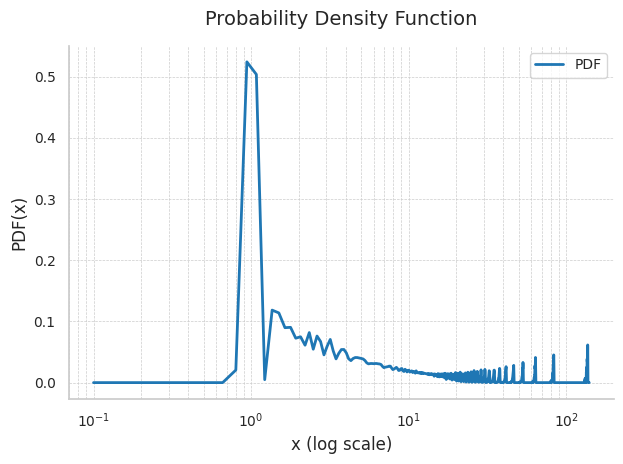

In [13]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()
ax.plot(ys, pdf_vals, color='#1f77b4', linewidth=2, label='PDF')
ax.set_xscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xlabel("x (log scale)", fontsize=12)
ax.set_ylabel("PDF(x)", fontsize=12)
ax.set_title("Probability Density Function", fontsize=14, pad=15)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()
ax.legend(fontsize=10, loc="best")

plt.tight_layout()
plt.show()

## Part 2: Level of significance of Haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

#### Load 97% Greengenes tree

In [14]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'))

In [15]:
n_leaves = tree.find_n_leaves()
print(n_leaves)

99322


In [16]:
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

#### Load Guerrero Negro dataset

In [17]:
gn_table_filepath = os.path.join(GN_DATA, 'gg_13_8_97ref_97clust_filtered_table.tsv')
table_df = utils.load_gn_seq_id_abundances(gn_table_filepath)

In [18]:
print(table_df)

                                        OTU ID  0-1mm  1-2mm  2-3mm  3-4mm  \
0                                      4428450    726    734     93     39   
1                                      4330730    778    577     93     47   
2                                      3918930     40     15     35      5   
3                                      3869470     27     54     38    280   
4                                      2602447     17    335    304    343   
...                                        ...    ...    ...    ...    ...   
8210  5f006efbc34601fff7629066cb5b1cd686b7740f      0      0      0      0   
8211  044ca5d9859649fa8a226a659cff0ee93e28626c      0      0      0      0   
8212  dc3d602dd09510aae6e564b142b202ecc64abe8d      0      0      0      0   
8213  e7e6b61ac9e0f280fe04d8430196c2e94ed7b46d      0      0      0      0   
8214  f75e630cf560c224600a4486f9d1f8a3a1fae496      0      0      0      0   

      4-5mm  5-6mm  6-10mm  10-22mm  22-34mm  34-49mm  Unnamed:

In [19]:
table_df_placed = table_df.iloc[:4301].copy()

In [20]:
cols = table_df_placed.columns[1:]
table_df_placed[cols] = table_df_placed[cols].div(table_df_placed[cols].sum(axis=0), axis=1)

In [21]:
leaf_idxs = seq_id2leaf_idx[table_df_placed['OTU ID']].values
table_df_placed.loc[:, 'Leaf Index'] = leaf_idxs
table_df_placed.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [22]:
print(table_df_placed)

       OTU ID     0-1mm     1-2mm     2-3mm     3-4mm     4-5mm     5-6mm  \
0     1636411  0.000000  0.000095  0.000000  0.000000  0.000000  0.000114   
1     2517611  0.000000  0.000095  0.000094  0.000000  0.000000  0.000000   
2     4436061  0.000000  0.000000  0.000000  0.000000  0.000000  0.000114   
3     1549742  0.000000  0.000000  0.000000  0.000000  0.000000  0.000114   
4     4478955  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...       ...       ...       ...       ...       ...       ...       ...   
4296  4361967  0.000103  0.000665  0.000094  0.000000  0.000092  0.000000   
4297  3942288  0.000103  0.000095  0.000000  0.000093  0.000000  0.000000   
4298  2773512  0.000103  0.000000  0.000000  0.000000  0.000000  0.000000   
4299  3617745  0.000000  0.000000  0.000000  0.000000  0.000092  0.000000   
4300  4067875  0.000000  0.000095  0.000188  0.000372  0.000000  0.000000   

        6-10mm   10-22mm   22-34mm   34-49mm  Unnamed: 11  Leaf Index  
0  

#### Compute Haar-like coordinates

In [23]:
Q, S = pcms.haar.sparsify(tree)

In [24]:
diff_s = table_df_placed['34-49mm'] - table_df_placed['0-1mm']

mask = diff_s != 0

values = diff_s[mask].values
indices = table_df_placed['Leaf Index'][mask].values
indptr = [0, len(values)]

diff = csc_matrix((values, indices, indptr), shape=(n_leaves,1))

In [25]:
coords = (Q.T @ diff).tocsc()

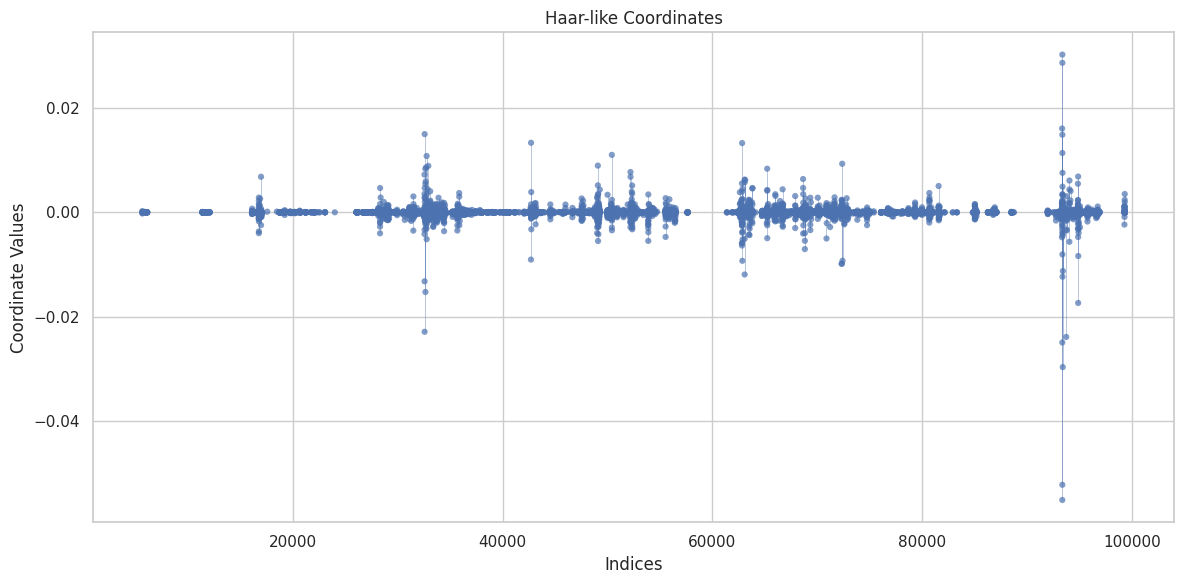

In [26]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Scatter points
sns.scatterplot(
    x=coords.indices,
    y=coords.data,
    s=20,
    color='b',
    alpha=0.7,
    edgecolor='none'
)

# Draw vertical lines from each point down to y=0
plt.vlines(
    x=coords.indices,
    ymin=0,
    ymax=coords.data,
    colors='b',
    alpha=0.4,
    linewidth=0.7
)

plt.xlabel('Indices')
plt.ylabel('Coordinate Values')
plt.title('Haar-like Coordinates')
plt.tight_layout()
plt.show()

In [27]:
dh_coords = coords.data**2 * S.diagonal()[coords.indices]
dh_indices = coords.indices[dh_coords != 0]
dh_coords = dh_coords[dh_coords != 0]

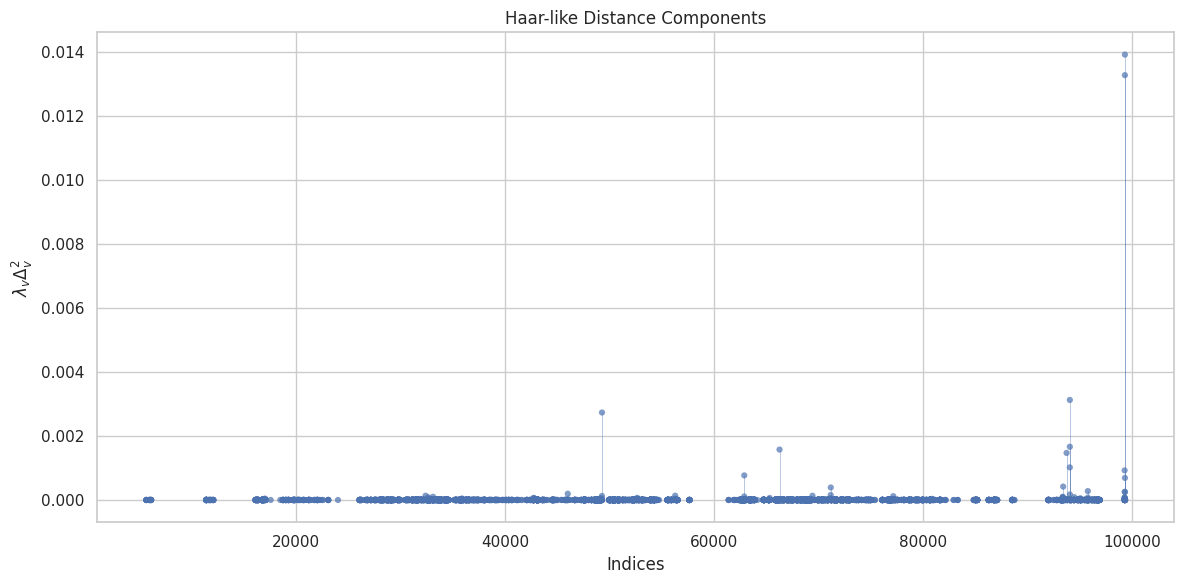

In [28]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Scatter points
sns.scatterplot(
    x=dh_indices,
    y=dh_coords,
    s=20,
    color='b',
    alpha=0.7,
    edgecolor='none'
)

# Draw vertical lines from each point down to y=0
plt.vlines(
    x=dh_indices,
    ymin=0,
    ymax=dh_coords,
    colors='b',
    alpha=0.4,
    linewidth=0.7
)

plt.xlabel('Indices')
plt.ylabel(r'$\lambda_v \Delta_v^2$')
plt.title('Haar-like Distance Components')
plt.tight_layout()
plt.show()